https://foss4g.tistory.com/1665

In [28]:
import cv2
import numpy as np
import os
import glob

In [29]:
import matplotlib.pyplot as plt

In [30]:
#image_path = './images_480p'
image_path = './images/saved_image_000.jpg'

In [31]:
# 체커보드의 차원 정의
# CHECKERBOARD = (6,9) # 체커보드 행과 열당 내부 코너 수
CHECKERBOARD = (9,6) # 체커보드 행과 열당 내부 코너 수
# CHECKERBOARD = (5,7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [32]:
# 각 체커보드 이미지에 대한 3D 점 벡터를 저장할 벡터 생성
objpoints = []
# 각 체커보드 이미지에 대한 2D 점 벡터를 저장할 벡터 생성
imgpoints = [] 
# 3D 점의 세계 좌표 정의
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
# https://github.com/urbste/ImprovedOcamCalib/blob/master/FisheyeDataSet/test_images/checkerboard_sizes.txt
#objp *= 0.0325
objp *= 0.0215
prev_img_shape = None

In [33]:
objp[0, 0:5, :]

array([[0.    , 0.    , 0.    ],
       [0.0215, 0.    , 0.    ],
       [0.043 , 0.    , 0.    ],
       [0.0645, 0.    , 0.    ],
       [0.086 , 0.    , 0.    ]], dtype=float32)

In [34]:
images = glob.glob('./images/*.jpg')

In [35]:
images

['./images/saved_image_018.jpg',
 './images/saved_image_011.jpg',
 './images/saved_image_010.jpg',
 './images/saved_image_015.jpg',
 './images/saved_image_006.jpg',
 './images/saved_image_003.jpg',
 './images/saved_image_005.jpg',
 './images/saved_image_002.jpg',
 './images/saved_image_019.jpg',
 './images/saved_image_012.jpg',
 './images/saved_image_008.jpg',
 './images/saved_image_001.jpg',
 './images/saved_image_009.jpg',
 './images/saved_image_007.jpg',
 './images/saved_image_013.jpg',
 './images/saved_image_017.jpg',
 './images/saved_image_000.jpg',
 './images/saved_image_016.jpg',
 './images/saved_image_004.jpg',
 './images/saved_image_014.jpg']

In [36]:
# 주어진 디렉터리에 저장된 개별 이미지의 경로 추출
# images = glob.glob(image_path + '/*.jpg')
# images = glob.glob('./ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_*.jpg')
for fname in images:
    img = cv2.imread(fname)
    # 그레이 스케일로 변환
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 체커보드 코너 찾기
    # 이미지에서 원하는 개수의 코너가 발견되면 ret = true
    ret, corners = cv2.findChessboardCorners(gray,
                                             CHECKERBOARD,
                                             cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    # 원하는 개수의 코너가 감지되면,
    # 픽셀 좌표 미세조정 -> 체커보드 이미지 표시
    if ret == True:
        objpoints.append(objp)
        # 주어진 2D 점에 대한 픽셀 좌표 미세조정
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        # 코너 그리기 및 표시
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    cv2.imshow('img',img)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()
h,w = img.shape[:2] # 480, 640
# 알려진 3D 점(objpoints) 값과 감지된 코너의 해당 픽셀 좌표(imgpoints) 전달, 카메라 캘리브레이션 수행
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [38]:
tvecs[-4]

array([[-0.1147002 ],
       [-0.04281362],
       [ 0.47504098]])

In [11]:
img = cv2.imread(images[0])
print(img.shape)

(720, 1280, 3)


In [12]:
mtx, dist

(array([[1.35745561e+03, 0.00000000e+00, 7.31862038e+02],
        [0.00000000e+00, 1.35721160e+03, 4.39804697e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 2.87362321e-02,  1.17548402e-01, -1.08876899e-05,
          2.27235180e-03, -5.09375304e-01]]))

In [13]:
# calibration_matrix_path = './aruco_marker/calibration_matrix_480p.npy'
# distortion_coefficients_path = './aruco_marker/distortion_coefficients_480p.npy'

calibration_matrix_path = './aruco_marker/calibration_matrix_fisheye.npy'
distortion_coefficients_path = './aruco_marker/distortion_coefficients_fisheye.npy'

In [ ]:
def get_calibrated_image(fname, mtx, dist):
    img = cv2.imread(fname)


    h,  w = img.shape[:2]
    ####################################################################3    
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
     
    # crop the image
    # x, y, w, h = roi
    # dst = dst[y:y+h, x:x+w]

    return img, dst

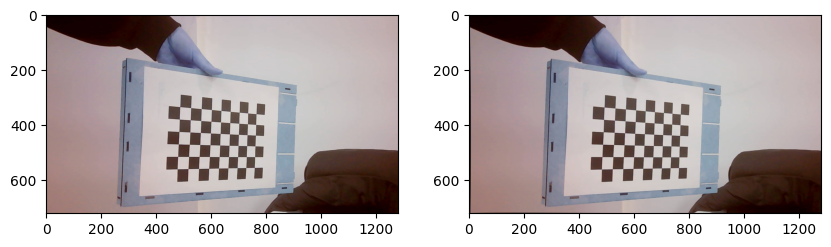

In [15]:
fig = plt.figure(figsize=(10, 10))

for fname in images:
    img, dst = get_calibrated_image(fname, mtx, dist)

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(img)
    ax1 = plt.subplot(1, 2, 2)
    ax1.imshow(dst)
    
    break

In [16]:
height, width, _ = img.shape
print(width, height)

1280 720


In [17]:
mtx0 = np.array([[360, 0, width/2], [0, 360, height/2], [0, 0, 1]])
# mtx0 = np.array([[1, 0, 516], [0, 1, 389], [0, 0, 1]])
dist0 = np.array([[0, 0, 0, 0, 0]])

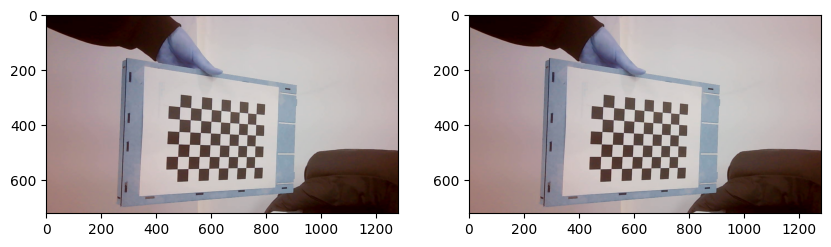

In [18]:
fig = plt.figure(figsize=(10, 10))

for fname in images:
    img, dst = get_calibrated_image(fname, mtx0, dist0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(img)
    ax1 = plt.subplot(1, 2, 2)
    ax1.imshow(dst)
    
    break

In [23]:
np.save(calibration_matrix_path, mtx)
np.save(distortion_coefficients_path, dist)

FileNotFoundError: [Errno 2] 그런 파일이나 디렉터리가 없습니다: './aruco_marker/calibration_matrix_fisheye.npy'

In [24]:
!ls ImprovedOcamCalib/FisheyeDataSet/test_images/

ls: 'ImprovedOcamCalib/FisheyeDataSet/test_images/'에 접근할 수 없습니다: 그런 파일이나 디렉터리가 없습니다
